In [2]:
import torch
from tensorflow import keras
from keras.datasets import imdb
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

# IMDB 리뷰 데이터셋 가져오기
(train_input, train_target), (test_input, test_target) =\
    imdb.load_data(num_words=500)

# 훈련/검증 세트 분리
train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42
)

# 패딩 처리
train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

In [3]:
# 파이토치 torch.tensor 자료형으로 변환
train_seq = torch.tensor(train_seq)
val_seq = torch.tensor(val_seq)

# 0, 1 정수형을 실수형으로 (파이토치에서 실수형을 기대하기 때문)
train_target = torch.tensor(train_target, dtype=torch.float32)
val_target = torch.tensor(val_target, dtype=torch.float32)

In [4]:
from torch.utils.data import TensorDataset, DataLoader

# TensorDataset: 가공된 입력과 타깃을 하나의 PyTorch 데이터셋으로 통합
train_dataset = TensorDataset(train_seq, train_target)
val_dataset = TensorDataset(val_seq, val_target)

# DataLoader: 32 배치 단위로, 훈련 세트는 섞어서(shuffle) 검증 데이터는 순서대로 나눠준다.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [5]:
import torch.nn as nn

# 층 구성
# 입력 -> 은닉(모든 출력 반환) -> 은닉(마지막 출력 반환) -> 출력

class IMDLstm(nn.Module):
    def __init__(self):
        super().__init__()

        # 입력 층: 파이토치는 입력층을 따로 명시하지 않음

        # 임베딩 층
        self.embedding = nn.Embedding(500, 16)

        # LSTM 층
        self.lstm = nn.LSTM(16, 8, num_layers=2, dropout=0.2, batch_first=True)  # 층을 2개 쌓음

        # 은닉 층
        self.dense = nn.Linear(8, 1)

        # 출력 층
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        x = self.dense(hidden[-1])
        outputs = self.dense(hidden[-1])

        return self.sigmoid(outputs)

In [6]:
from torchinfo import summary
model = IMDLstm()

summary(model)

Layer (type:depth-idx)                   Param #
IMDLstm                                  --
├─Embedding: 1-1                         8,000
├─LSTM: 1-2                              1,408
├─Linear: 1-3                            9
├─Sigmoid: 1-4                           --
Total params: 9,417
Trainable params: 9,417
Non-trainable params: 0

In [7]:
# 모델을 gpu로 보내기

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

IMDLstm(
  (embedding): Embedding(500, 16)
  (lstm): LSTM(16, 8, num_layers=2, batch_first=True, dropout=0.2)
  (dense): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [8]:
import torch.optim as optim
# 모델 컴파일 - optimizer, loss function, 평가 지표

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [9]:
train_hist = []
val_hist = []
patience = 2
best_loss = -1
early_stopping_counter = 0

epochs = 100
for epoch in  range(epochs):
    model.train()
    train_loss = 0

    # 학습 - 32 배치 단위
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # 검증 - 32 배치 단위
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()

    # 훈련/검증 평균 손실 계산
    train_loss = train_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)

    # 평균 손실 기록
    train_hist.append(train_loss)
    val_hist.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - val_loss: {val_loss:.4f}")

    if best_loss == -1 or val_loss < best_loss:
        best_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_lstm_model.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print(f"Early Stopping - {epoch+1} epochs")
            break

Epoch 1/100 - loss: 0.6757 - val_loss: 0.6233
Epoch 2/100 - loss: 0.6280 - val_loss: 0.5992
Epoch 3/100 - loss: 0.5979 - val_loss: 0.6101
Epoch 4/100 - loss: 0.5654 - val_loss: 0.5482
Epoch 5/100 - loss: 0.5538 - val_loss: 0.5325
Epoch 6/100 - loss: 0.6131 - val_loss: 0.6560
Epoch 7/100 - loss: 0.5986 - val_loss: 0.5575
Early Stopping - 7 epochs


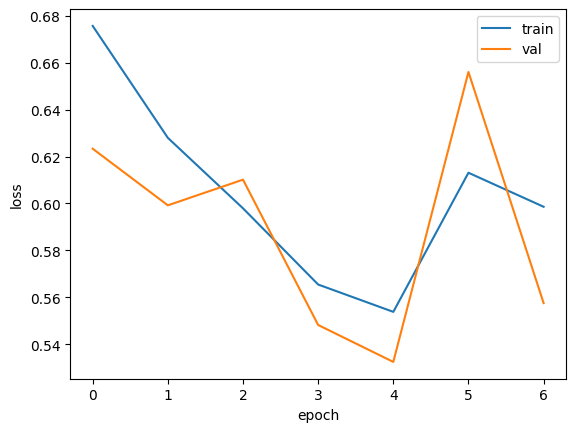

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_hist, label='train')
plt.plot(val_hist, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [11]:
model.eval()
corrects = 0
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predicts = outputs.squeeze() > 0.5
        corrects += (predicts == targets).sum().item()

accuracy = corrects / len(val_dataset)
print(f"검증 정확도: {accuracy:.4f}")

검증 정확도: 0.7144
